
 KIỂM TRA SUY BIẾN: Ising
| Level | Energy (E)      | Diff (E-E0)     |
|-------|-----------------|-----------------|
| E0    | -3.0000         | 0.0000          | (*)
| E1    | -3.0000         | 0.0000          | (*)
| E2    | -1.0000         | 2.0000          |
| E3    | -1.0000         | 2.0000          |
|-------------------------------------------|
Gap (E1 - E0) = 0.000000
Trang thai co ban suy bien


 KIỂM TRA SUY BIẾN: Heisenberg
| Level | Energy (E)      | Diff (E-E0)     |
|-------|-----------------|-----------------|
| E0    | -4.3723         | 0.0000          | (*)
| E1    | -3.2361         | 1.1362          |
| E2    | -2.3028         | 2.0695          |
| E3    | -2.3028         | 2.0695          |
|-------------------------------------------|
Gap (E1 - E0) = 1.136213
Trang thai co ban khong suy bien

Đã lưu hình 1 tại: results/QFI_Evolution_N=4_J=1.0_h=0.2_T=10_alpha=1.0.png
Đã lưu hình 2 tại: results/Combined_Plots_N=4_J=1.0_h=0.2_T=10_alpha=1.0.png


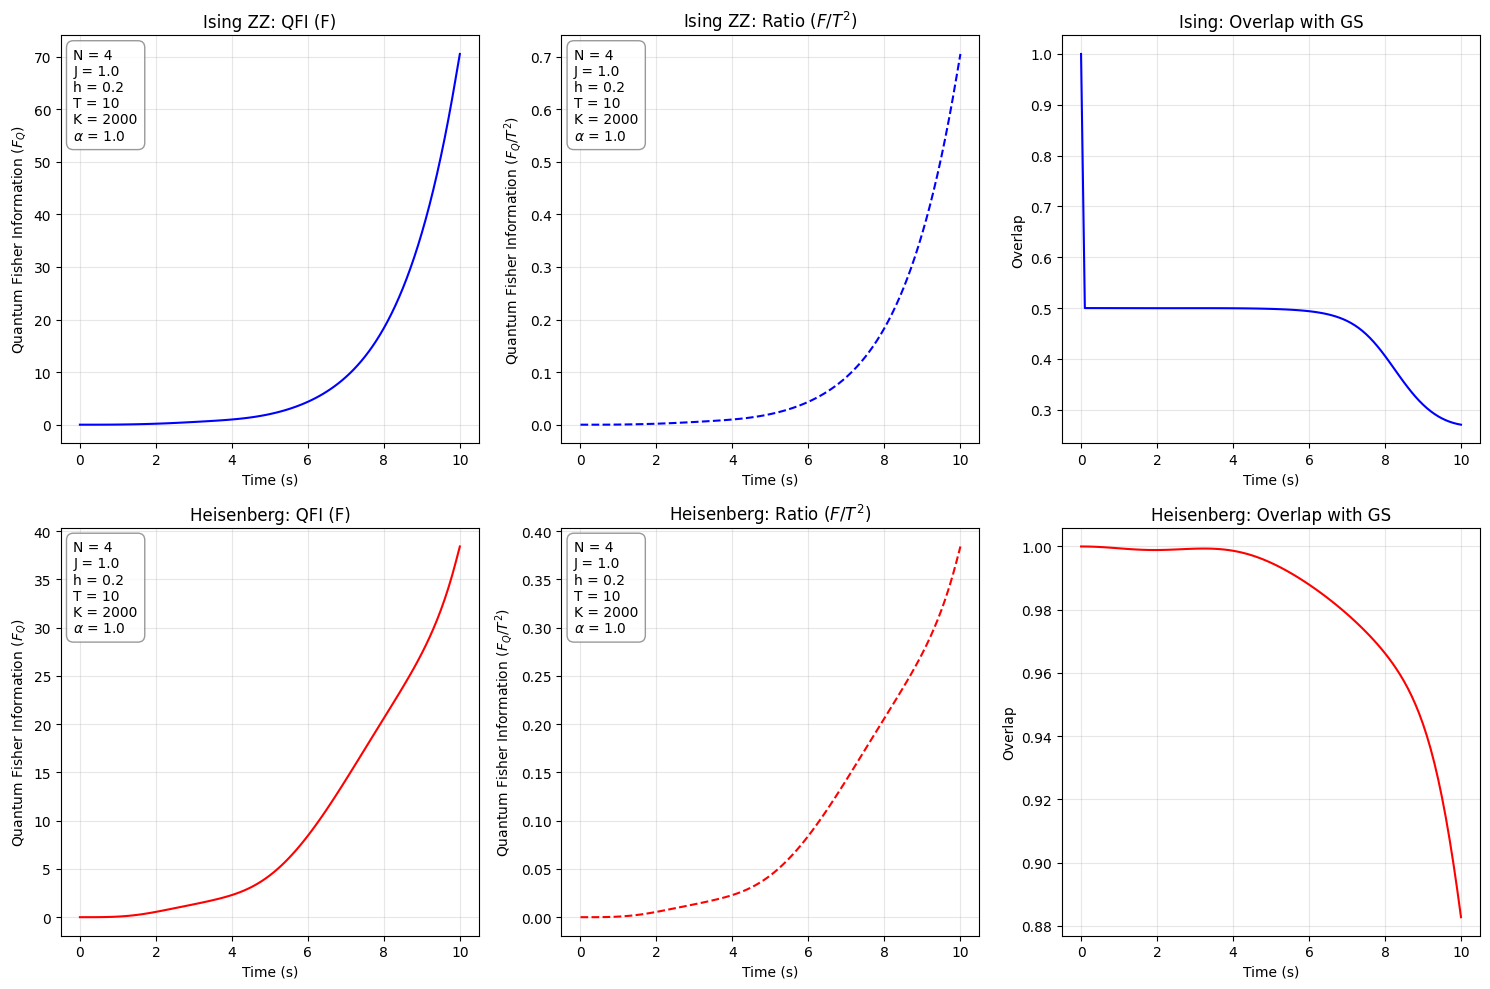

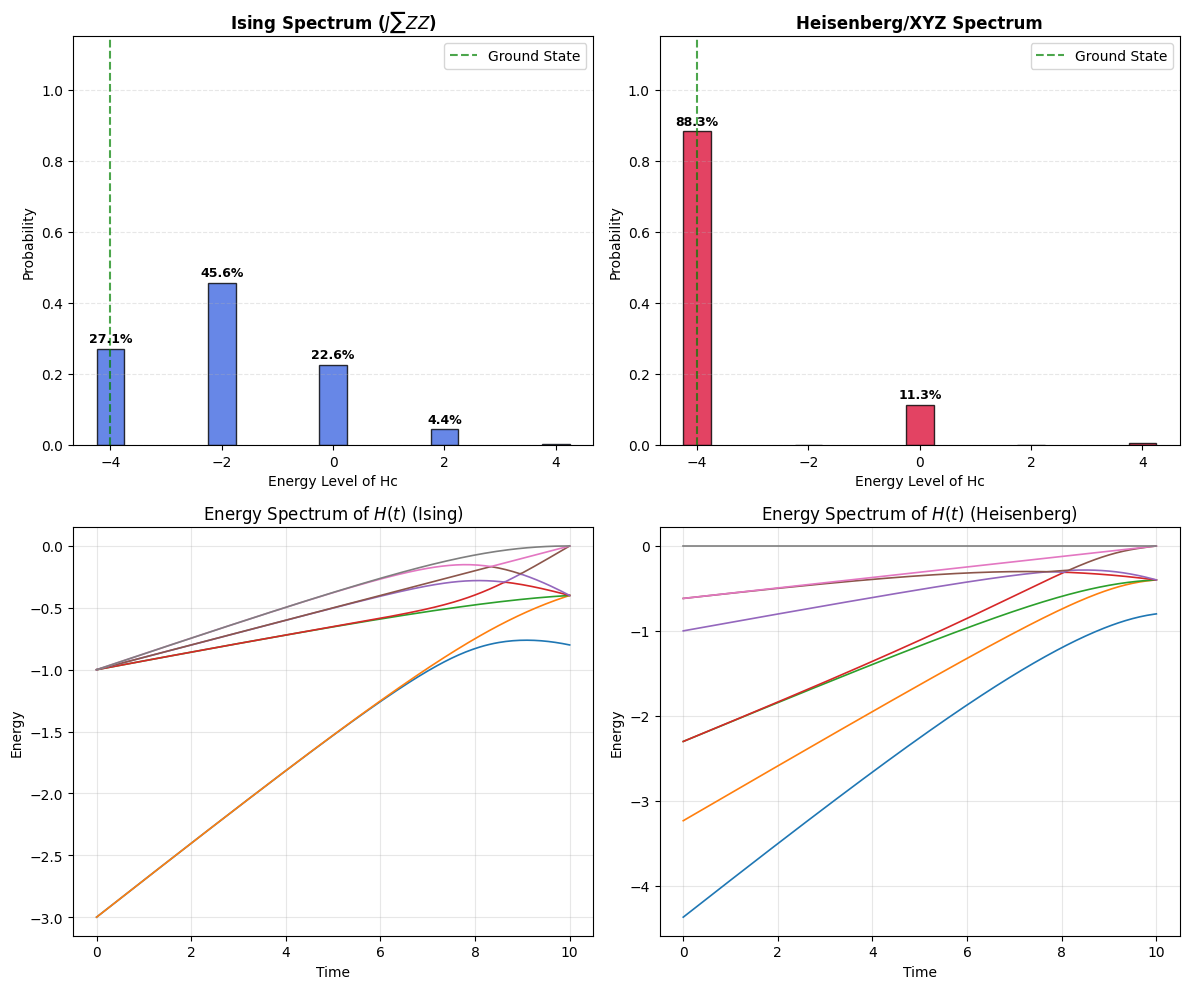

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
from functools import reduce

def pauli_mats():
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    return I, X, Y, Z

def tensor_prod(op_list):
    return reduce(np.kron, op_list)

def interaction(N, op_type = 'Z'):
    I, X, Y, Z = pauli_mats()

    op_map = {
                'X' : X,
                'Y' : Y,
                'Z' : Z
              }

    Op = op_map[op_type]
    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)
    for j in range(N-1):
        ops = [I] * N
        ops[j] = Op
        ops[j+1] = Op

        H += tensor_prod(ops)
    return H

def Hd_ZZ(N, J):
    I, _, _, Z = pauli_mats()
    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)

    for j in range(N-1):
        ops = [I] * N
        ops[j] = Z
        ops[j+1] = Z
        term = tensor_prod(ops)
        # term = reduce(np.kron, ops)

        H += J * term
    return H

def Hc_sumX(N):
    I, X, _, _ = pauli_mats()
    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)

    for j in range(N):
        ops = [I] * N
        ops[j] = X
        term = tensor_prod(ops)

        H += term
    return H

def ground_state(H):
    E, V = eigh(H, subset_by_index=[0, 0])
    return E[0], V[:,0]

def get_schedule(t, T, alpha):
    s = (t/T)**alpha
    return 1-s, s

def check_degeneracy(H, model_name="S", tol=1e-10):
    vals = eigh(H, subset_by_index=[0, 3], eigvals_only=True)
    E0 = vals[0]
    E1 = vals[1]
    gap = E1 - E0
    degenerate = gap < tol

    print(f"\n" + "="*45)
    print(f" KIỂM TRA SUY BIẾN: {model_name}")
    print("="*45)

    print(f"| {'Level':<5} | {'Energy (E)':<15} | {'Diff (E-E0)':<15} |")
    print(f"|{'-'*7}|{'-'*17}|{'-'*17}|")

    for i, E in enumerate(vals):
        diff = E - E0
        # Đánh dấu (*) nếu trạng thái đó thuộc về Ground State (suy biến)
        marker = " (*)" if diff < tol else ""
        print(f"| E{i:<4} | {E:<15.4f} | {diff:<15.4f} |{marker}")
        # print(f"E{i}: {E}")
    # print(f"E0 = {E0}")
    # print(f"E1 = {E1}")
    # print(f"gap = {gap}")
    print(f"|{'-'*43}|")

    print(f"Gap (E1 - E0) = {gap:.6f}")
    if degenerate:
        print("Trang thai co ban suy bien")
    else:
        print("Trang thai co ban khong suy bien")

    print("="*45 + "\n")    
    return degenerate, gap



def Hc_spectrum(N):
    print(f" Phan tich pho nang luong Hc")

    Hc = Hc_sumX(N)
    evals = eigh(Hc, eigvals_only=True)
    evals_rounded = np.round(evals)
    unique_energies, count  = np.unique(evals_rounded, return_counts=True)
    print(f"Dimension: {2**N}")
    print("Energy Levels:")
    print(f"{'Energy (E)':<15} | {'Degeneracy':<20} | {'Tỷ lệ %':<10}")

    for E, count in zip(unique_energies, count):
        percentage = (count / (2**N)) * 100
        print(f"{E:<15.1f} | {count:<20} | {percentage:.1f}%")

def plot_final_energy_distribution(ax, H_basis, psi_final, title, color):
    """
    Chiếu trạng thái psi_final lên các mức năng lượng của H_basis (thường là Hc)
    và vẽ biểu đồ phân bố xác suất.
    """
    # 1. Chéo hóa Hamiltonian cơ sở để lấy phổ năng lượng
    evals, evecs = eigh(H_basis)

    # 2. Tính xác suất tại từng trạng thái riêng: P_i = |<E_i | psi>|^2
    # evecs[:, i] là vector riêng thứ i
    overlaps = np.abs(psi_final.conj() @ evecs)**2

    # 3. Gom nhóm các mức năng lượng giống nhau (Degeneracy)
    evals_rounded = np.round(evals, decimals=4)
    unique_energies = np.unique(evals_rounded)

    grouped_probs = []
    for E in unique_energies:
        # Lấy index của tất cả các trạng thái có cùng mức năng lượng E
        indices = np.where(evals_rounded == E)[0]
        # Cộng tổng xác suất
        prob_sum = np.sum(overlaps[indices])
        grouped_probs.append(prob_sum)

    # 4. Vẽ biểu đồ
    bars = ax.bar(unique_energies, grouped_probs, width=0.5, color=color, alpha=0.8, edgecolor='black')

    # Thêm nhãn % lên đầu cột (chỉ hiện nếu > 1%)
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height*100:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Đánh dấu Ground State
    E_min = unique_energies[0]
    ax.axvline(E_min, color='green', linestyle='--', alpha=0.7, label='Ground State')

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(f'Energy Level of Hc', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_ylim(0, 1.15) # Chừa chỗ cho text
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    return unique_energies[0], grouped_probs[0] # Trả về E_min và xác suất thành công

def plot_energy_spectrum_vs_time(N, J, h, T, K, alpha, model_type, ax=None):
    """
    Vẽ phổ năng lượng của H(t) theo thời gian t.
    """
    # Xây dựng Hd và Hc
    if model_type == "Ising":
        Hd = J * interaction(N, 'Z')
    elif model_type == "Heisenberg":
        H_XX = interaction(N, 'X')
        H_YY = interaction(N, 'Y')
        H_ZZ = interaction(N, 'Z')
        Hd = -0.5 * J * (H_XX + H_YY) + J * H_ZZ
    Hc = Hc_sumX(N)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    times = np.linspace(0, T, K//10 + 1)  # Giảm số điểm để nhanh
    all_energies = []

    for t in times:
        A_t, B_t = get_schedule(t, T, alpha)
        H_t = A_t * Hd + B_t * (h * Hc)
        evals = eigh(H_t, eigvals_only=True)
        all_energies.append(np.sort(evals))  # Sắp xếp tăng dần

    all_energies = np.array(all_energies)  # shape: (len(times), 2^N)

    # Vẽ từng mức năng lượng
    for i in range(min(8, 2**N)):  # Chỉ vẽ 8 mức đầu để rõ
        ax.plot(times, all_energies[:, i], '-', linewidth=1.2, label=f'E{i}' if i < 4 else "")
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy')
    ax.set_title(f'Energy Spectrum of $H(t)$ ({model_type})')
    ax.grid(True, alpha=0.3)
    if min(8, 2**N) <= 4:
        ax.legend()

def qfi_during_anneal(N, J, h, T, K, alpha, model_type, check_deg = True):
    if model_type == "Ising":
        # Hd = Hd_ZZ(N, J)
        Hd = J * interaction(N, 'Z')
    elif model_type == "Heisenberg":
        H_XX = interaction(N, 'X')
        H_YY = interaction(N, 'Y')
        H_ZZ = interaction(N, 'Z')
        Hd = -0.5 * J * (H_XX + H_YY) + J * H_ZZ

    if check_deg:
        check_degeneracy(Hd, model_name=model_type)

    # Hd = Hd_ZZ(N, J)
    Xsum = Hc_sumX(N)
    E0, psi0 = ground_state(Hd)
    psi = psi0.copy()
    dt = T/K
    dim = 2**N
    U = np.eye(dim, dtype=complex)
    G = np.zeros((dim, dim), dtype=complex)

    times = []
    FQs = []
    overlaps = []

    for k in range(K):
        t = k*dt

        A_t, B_t = get_schedule(t, T , alpha)

        dHdh = B_t * Xsum

        term = U.conj().T @ dHdh @ U
        G += term * dt

        tm = t + 0.5 * dt
        A_mid, B_mid = get_schedule(tm, T , alpha)
        Hmid = A_mid * Hd + B_mid * (h * Xsum)

        Ustep = expm(-1j * Hmid * dt)
        U = Ustep @ U
        psi = Ustep @ psi

        if k % max(1, K//100) == 0:
            # Hamiltonian tức thời H(t) tại thời điểm t (không phải Hmid!)
            H_t = A_t * Hd + B_t * (h * Xsum)
            # Ground state tức thời
            _, psi_gs = ground_state(H_t)
            # Overlap = |<psi_gs | psi>|^2
            overlap = np.abs(np.vdot(psi_gs, psi))**2
            overlaps.append(overlap)

            G_psi = G @ psi0
            mean = np.vdot(psi0, G_psi)
            mean_sq = np.vdot(psi0, G @ G_psi)

            var = mean_sq - (mean * np.conj(mean))
            FQ = 4 * np.real(var)

            times.append(t)
            FQs.append(FQ)


    # Final step
    t = T
    A_t, B_t = get_schedule(t, T, alpha)
    H_t = A_t * Hd + B_t * (h * Xsum)
    _, psi_gs = ground_state(H_t)
    overlap = np.abs(np.vdot(psi_gs, psi))**2
    overlaps.append(overlap)

    G_psi = G @ psi0
    mean = np.vdot(psi0, G_psi)
    mean_sq = np.vdot(psi0, G @ G_psi)
    var = mean_sq - (mean * np.conj(mean))
    FQ_T = 4 * np.real(var)

    times.append(t)
    FQs.append(FQ_T)
    return np.array(times), np.array(FQs), psi, np.array(overlaps) 


# def qfi_during_anneal(N, J, h, T, K, alpha, model_type, check_deg=True):
#     I, X, Y, Z = pauli_mats()
    
#     # Xây dựng Hd
#     if model_type == "Ising":
#         Hd = J * interaction(N, 'Z')
#     elif model_type == "Heisenberg":
#         H_XX = interaction(N, 'X')
#         H_YY = interaction(N, 'Y')
#         H_ZZ = interaction(N, 'Z')
#         Hd = -0.5 * J * (H_XX + H_YY) + J * H_ZZ  # Heisenberg: XX + YY + ZZ

#     if check_deg:
#         check_degeneracy(Hd, model_name=model_type)

#     # Xây dựng Hc = sum X_j
#     Xsum = Hc_sumX(N)
    
#     # Trạng thái ban đầu: ground state của Hd
#     _, psi0 = ground_state(Hd)
#     psi = psi0.copy()
    
#     dt = T / K
#     times = []
#     FQs = []
#     overlaps = []
#     for k in range(K + 1):  # Bao gồm cả t=0 và t=T
#         t = k * dt
#         A_t, B_t = get_schedule(t, T, alpha)
        
#         # Hamiltonian tại thời điểm t
#         H_t = A_t * Hd + B_t * (h * Xsum)
#         E_gs, psi_gs = ground_state(H_t)  # ground state tức thời
#         overlap = np.abs(np.vdot(psi_gs, psi))**2
#         overlaps.append(overlap)

#         # Generator: dH/dh = B_t * Xsum
#         G_t = B_t * Xsum
        
#         # Tính QFI trên TRẠNG THÁI HIỆN TẠI psi
#         exp_G = np.vdot(psi, G_t @ psi)           # <G>
#         exp_G2 = np.vdot(psi, G_t @ G_t @ psi)    # <G^2>
#         var = np.real(exp_G2 - np.abs(exp_G)**2)  # Var(G) = <G^2> - |<G>|^2
#         FQ = 4 * var
        
#         times.append(t)
#         FQs.append(FQ)
        
#         # Tiến triển trạng thái (trừ bước cuối)
#         if k < K:
#             # Dùng midpoint rule cho chính xác hơn
#             t_mid = t + 0.5 * dt
#             A_mid, B_mid = get_schedule(t_mid, T, alpha)
#             H_mid = A_mid * Hd + B_mid * (h * Xsum)
#             U_step = expm(-1j * H_mid * dt)
#             psi = U_step @ psi

#     return np.array(times), np.array(FQs), psi, np.array(overlaps) 

if __name__ == "__main__":
    N = 4
    J = 1.0
    u = 1.0
    h = 0.2
    T = 10
    K = 2000
    alpha = 1.0
    tol = 1e-10

    t1, f1, psi_ising, ov1 = qfi_during_anneal(N, J, h, T, K, alpha, "Ising")
    r1 = f1/(T**2)

    t2, f2, psi_heis, ov2 = qfi_during_anneal(N, J, h, T, K, alpha, "Heisenberg")
    r2 = f2/(T**2)

    Hc = Hc_sumX(N)
    # psi_ising = qfi_during_anneal(N, J, h, T, K, alpha, "Ising")
    # psi_heis = qfi_during_anneal(N, J, h, T, K, alpha, "Heisenberg")
    # Hd = Hd_ZZ(N, J)
    # check_degeneracy(Hd, tol)
    # Hc_spectrum(N)

    # plt.figure(figsize=(10, 6))
    #
    # plt.plot(time_arr, ratio, label=f'N={N}, h={h}', color='b', linewidth=2)
    #
    # plt.title(f'Quantum Fisher Information during Annealing (Alpha={alpha})')
    # plt.xlabel('Time (t)')
    # plt.ylabel('QFI ($F_Q$)')
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.legend()
    #
    # plt.show()

    # --- VẼ ĐỒ THỊ (2 Subplots) ---
    fig, axs = plt.subplots(2, 3, figsize=(15,10))

    info_str = "\n".join([
        f"N = {N}",
        f"J = {J}",
        f"h = {h}",
        f"T = {T}",
        f"K = {K}",
        rf"$\alpha$ = {alpha}"
    ])

    box_props = dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.8)

    # Ising Plots
    axs[0, 0].plot(t1, f1, 'b-'); axs[0, 0].set_title('Ising ZZ: QFI (F)')
    axs[0, 0].set_xlabel('Time (s)'); axs[0, 0].set_ylabel('Quantum Fisher Information ($F_Q$)')
    axs[0, 0].text(0.03, 0.97, info_str, transform=axs[0, 0].transAxes, ha='left', va='top', fontsize=10, bbox=box_props)

    axs[0, 1].plot(t1, r1, 'b--'); axs[0, 1].set_title('Ising ZZ: Ratio ($F/T^2$)')
    axs[0, 1].set_xlabel('Time (s)'); axs[0, 1].set_ylabel('Quantum Fisher Information ($F_Q/T^2$)')
    axs[0, 1].text(0.03, 0.97, info_str, transform=axs[0, 1].transAxes, ha='left', va='top', fontsize=10, bbox=box_props)

    # Heisenberg Plots
    axs[1, 0].plot(t2, f2, 'r-'); axs[1, 0].set_title('Heisenberg: QFI (F)')
    axs[1, 0].set_xlabel('Time (s)'); axs[1, 0].set_ylabel('Quantum Fisher Information ($F_Q$)')
    axs[1, 0].text(0.03, 0.97, info_str, transform=axs[1, 0].transAxes, ha='left', va='top', fontsize=10, bbox=box_props)
    
    axs[1, 1].plot(t2, r2, 'r--'); axs[1, 1].set_title('Heisenberg: Ratio ($F/T^2$)')
    axs[1, 1].set_xlabel('Time (s)'); axs[1, 1].set_ylabel('Quantum Fisher Information ($F_Q/T^2$)')
    axs[1, 1].text(0.03, 0.97, info_str, transform=axs[1, 1].transAxes, ha='left', va='top', fontsize=10, bbox=box_props)


    # Vẽ overlap
    axs[0, 2].plot(t1, ov1, 'b-'); axs[0, 2].set_title('Ising: Overlap with GS')
    axs[0, 2].set_xlabel('Time (s)'); axs[0, 2].set_ylabel('Overlap')
    axs[0, 2].grid(True, alpha=0.3)

    axs[1, 2].plot(t2, ov2, 'r-'); axs[1, 2].set_title('Heisenberg: Overlap with GS')
    axs[1, 2].set_xlabel('Time (s)'); axs[1, 2].set_ylabel('Overlap')
    axs[1, 2].grid(True, alpha=0.3)

    for ax in axs.flat: ax.grid(True, alpha=0.3)

    output_folder = "results"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    params_str = f"N={N}_J={J}_h={h}_T={T}_alpha={alpha}"

    plt.tight_layout()

    # fig.savefig('QFI_Evolution.png', dpi=300, bbox_inches='tight')

    filename_1 = f"QFI_Evolution_{params_str}.png"
    save_path_1 = os.path.join(output_folder, filename_1)
    
    fig.savefig(save_path_1, dpi=300, bbox_inches='tight')
    print(f"Đã lưu hình 1 tại: {save_path_1}")

    fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))
    # fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    # fig2.suptitle(f"Energy Spectrum Distribution (Degeneracy) of Hd and H_total", fontsize=16)

    # Vẽ phổ Ising
    # plot_final_energy_distribution(ax3, Hc, psi_ising, r"Ising Spectrum ($J \sum ZZ$)", "royalblue")
    plot_final_energy_distribution(axs2[0, 0], Hc, psi_ising, r"Ising Spectrum ($J \sum ZZ$)", "royalblue")

    # Vẽ phổ Heisenberg/XYZ
    # plot_final_energy_distribution(ax4, Hc, psi_heis, "Heisenberg/XYZ Spectrum", "crimson")
    plot_final_energy_distribution(axs2[0, 1], Hc, psi_heis, "Heisenberg/XYZ Spectrum", "crimson")

    plot_energy_spectrum_vs_time(N, J, h, T, K, alpha, "Ising", ax=axs2[1, 0])
    plot_energy_spectrum_vs_time(N, J, h, T, K, alpha, "Heisenberg", ax=axs2[1, 1])

    # plt.tight_layout()
    # fig2.savefig('Energy_Distribution.png', dpi=300, bbox_inches='tight')

    # filename_2 = f"Energy_Dist_{params_str}.png"
    # save_path_2 = os.path.join(output_folder, filename_2)
    
    # fig2.savefig(save_path_2, dpi=300, bbox_inches='tight')
    # print(f"Đã lưu hình 2 tại: {save_path_2}")

    # fig_spec, axes_spec = plt.subplots(1, 2, figsize=(14, 5))
    # plot_energy_spectrum_vs_time(N, J, h, T, K, alpha, "Ising", ax=axes_spec[0])
    # plot_energy_spectrum_vs_time(N, J, h, T, K, alpha, "Heisenberg", ax=axes_spec[1])
    plt.tight_layout()
    # plt.savefig(os.path.join(output_folder, f"Energy_Spectrum_{params_str}.png"), dpi=300)
    filename_2 = f"Combined_Plots_{params_str}.png"
    save_path_2 = os.path.join(output_folder, filename_2)
    
    fig2.savefig(save_path_2, dpi=300, bbox_inches='tight')
    print(f"Đã lưu hình 2 tại: {save_path_2}")
    plt.show()

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    #
    # # Đồ thị 1: Giá trị QFI (F)
    # ax1.plot(time_arr, fqs_arr, color='blue', linewidth=2, label='QFI ($F_Q$)')
    # ax1.set_ylabel('Quantum Fisher Information ($F_Q$)', fontsize=12)
    # ax1.set_title(f'Evolution of QFI and Efficiency Ratio (N={N}, T={T})', fontsize=14)
    # ax1.grid(True, linestyle='--', alpha=0.7)
    # ax1.legend(loc='upper left')
    #
    # # Đồ thị 2: Tỷ lệ F / T^2
    # ax2.plot(time_arr, ratio, color='red', linewidth=2, label='Ratio ($F_Q / T^2$)')
    # ax2.set_xlabel('Time (t)', fontsize=12)
    # ax2.set_ylabel('Efficiency Ratio ($F_Q / T^2$)', fontsize=12)
    # ax2.grid(True, linestyle='--', alpha=0.7)
    # ax2.legend(loc='upper left')
    #
    # plt.tight_layout()
    # plt.show()

--- SWAPPED ANNEALING (X -> ZZ) ---

Final QFI: 7.08
Success Probability (Ground State ZZ): 97.97%


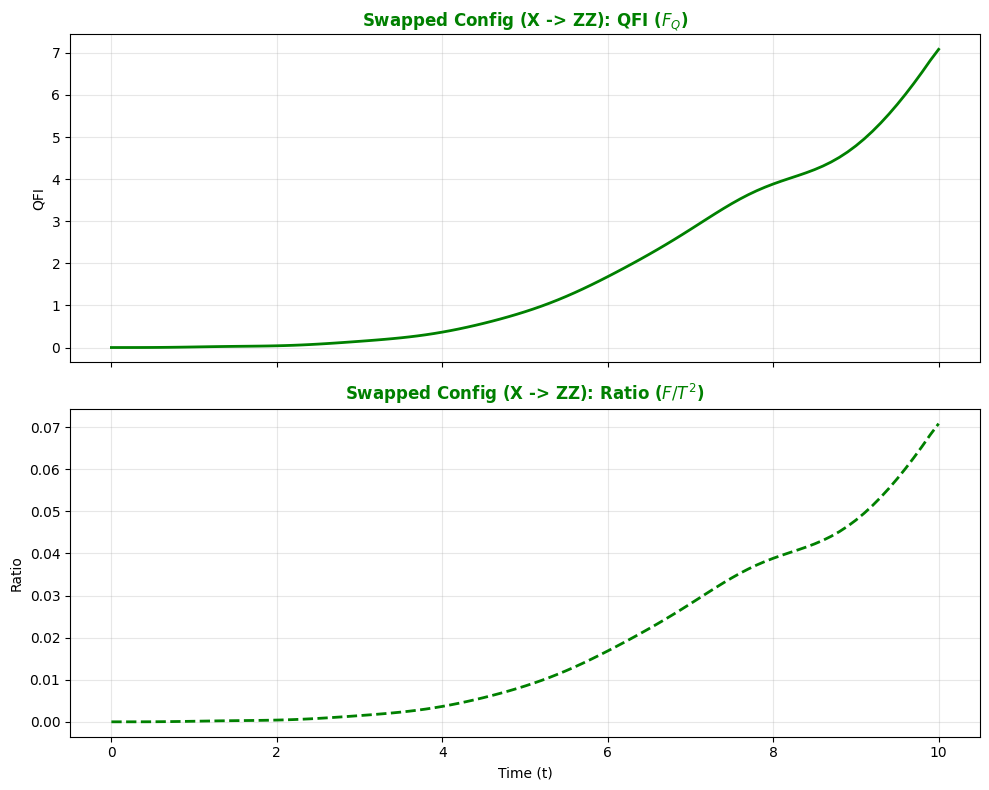

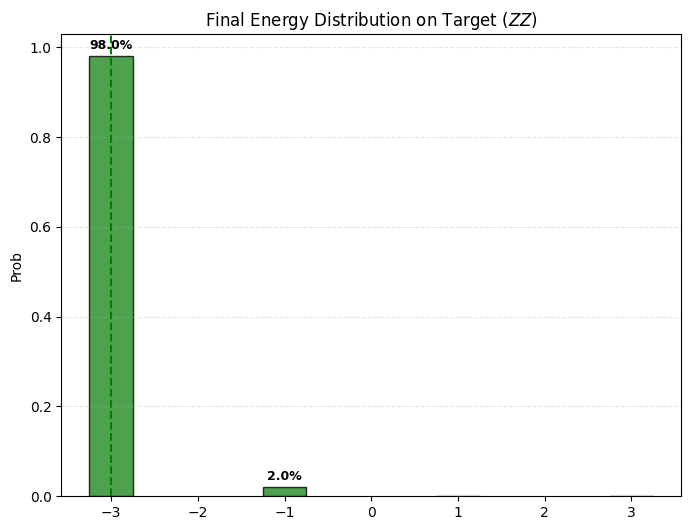

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
from functools import reduce


def ground_state(H):
    dim = H.shape[0]
    perturbation = 1e-10 * np.random.rand(dim, dim)
    perturbation = (perturbation + perturbation.conj().T)/2
    E, V = eigh(H + perturbation, subset_by_index=[0, 0])
    return E[0], V[:, 0]

def get_schedule(t, T, alpha):
    s = (t/T)**alpha
    return 1-s, s

# --- HÀM VẼ PHÂN BỐ NĂNG LƯỢNG ---
def plot_final_energy_distribution(ax, H_target, psi_final, title, color):
    evals, evecs = eigh(H_target)
    overlaps = np.abs(psi_final.conj() @ evecs)**2
    evals_rounded = np.round(evals, decimals=4)
    unique_energies = np.unique(evals_rounded)

    grouped_probs = []
    for E in unique_energies:
        indices = np.where(evals_rounded == E)[0]
        grouped_probs.append(np.sum(overlaps[indices]))

    bars = ax.bar(unique_energies, grouped_probs, width=0.5, color=color, alpha=0.8, edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        if height > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    E_min = unique_energies[0]
    ax.axvline(E_min, color='green', linestyle='--', label='Ground State')
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Prob')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    return grouped_probs[0]

# ==========================================
# ENGINE MÔ PHỎNG ĐÃ SỬA (SWAPPED)
# ==========================================
def qfi_swapped_anneal(N, J, h, T, K, alpha):
    """
    Chạy quá trình: Start(X) -> Target(ZZ)
    """
    # 1. HAMILTONIAN XUẤT PHÁT (Hd): Sum X
    # Dùng dấu âm để Ground State là |++++>
    Hd =  h * Hc_sumX(N)

    # 2. HAMILTONIAN ĐÍCH (Hc): Sum ZZ
    # Dùng dấu âm để Ground State là GHZ (|00..0> + |11..1>)
    Hc =  J * interaction(N, 'Z')

    # Tìm trạng thái ban đầu của Hd
    E0, psi0 = ground_state(Hd)
    psi = psi0.copy()

    dt = T/K
    dim = 2**N
    U = np.eye(dim, dtype=complex)
    G = np.zeros((dim, dim), dtype=complex)

    times = []
    FQs = []

    for k in range(K):
        t = k*dt
        _, B_t = get_schedule(t, T, alpha)

        # --- GENERATOR MỚI ---
        # Tham số cần đo bây giờ là J (gắn với ZZ), nên dH/dJ = Hc (phần ZZ)
        # Lưu ý: Trong H(t) = A*Hd + B*Hc, đạo hàm theo J (biên độ của Hc) là B*Hc
        dH_param = B_t * Hc

        term = U.conj().T @ dH_param @ U
        G += term * dt

        # Evolution
        tm = t + 0.5 * dt
        A_mid, B_mid = get_schedule(tm, T, alpha)

        # H(t) = (1-s)*Hd + s*Hc
        Hmid = A_mid * Hd + B_mid * Hc

        Ustep = expm(-1j * Hmid * dt)
        U = Ustep @ U
        psi = Ustep @ psi

        if k % max(1, K//100) == 0:
            G_psi = G @ psi0
            mean = np.vdot(psi0, G_psi)
            var = np.vdot(psi0, G @ G_psi) - (mean * np.conj(mean))
            FQ = 4 * np.real(var)
            times.append(t)
            FQs.append(FQ)

    # Điểm cuối
    G_psi = G @ psi0
    mean = np.vdot(psi0, G_psi)
    var = np.vdot(psi0, G @ G_psi) - (mean * np.conj(mean))
    FQ_T = 4 * np.real(var)
    times.append(T)
    FQs.append(FQ_T)

    return np.array(times), np.array(FQs), psi, Hc # Trả về Hc để vẽ

# ==========================================
# MAIN
# ==========================================
if __name__ == "__main__":
    N = 4
    J = 1.0
    h = 1.0  # Tăng h lên để khởi tạo mạnh
    T = 10.0
    K = 1000
    alpha = 1.0

    print(f"--- SWAPPED ANNEALING (X -> ZZ) ---")

    # 1. Chạy mô phỏng
    t, f, psi_final, H_target_ZZ = qfi_swapped_anneal(N, J, h, T, K, alpha)
    r = f / (T**2)

    # 2. Vẽ QFI & Ratio
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(t, f, 'g-', linewidth=2)
    axs[0].set_title(f'Swapped Config (X -> ZZ): QFI ($F_Q$)', color='green', fontweight='bold')
    axs[0].set_ylabel('QFI')
    axs[0].grid(True, alpha=0.3)

    axs[1].plot(t, r, 'g--', linewidth=2)
    axs[1].set_title(f'Swapped Config (X -> ZZ): Ratio ($F/T^2$)', color='green', fontweight='bold')
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('Time (t)')
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # 3. Vẽ Phân bố năng lượng tại Đích (ZZ)
    fig2, ax = plt.subplots(figsize=(8, 6))
    prob = plot_final_energy_distribution(ax, H_target_ZZ, psi_final,
                                   "Final Energy Distribution on Target ($ZZ$)", "forestgreen")

    print(f"\nFinal QFI: {f[-1]:.2f}")
    print(f"Success Probability (Ground State ZZ): {prob*100:.2f}%")

    plt.show()